In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)
import seaborn as sns

In [2]:
df = pd.read_csv('datahouse29.csv')


FileNotFoundError: [Errno 2] No such file or directory: 'datahouse29.csv'

In [ ]:
df.head()

In [ ]:
df['price'] = df['price'].str.replace(" ","")

In [ ]:
df['size'] = df['size'].astype(float)
df['price'] = df['price'].astype(float)

In [ ]:
df.head()

In [ ]:
df2 = df.drop_duplicates()

In [ ]:
df2.shape

In [ ]:
df2.isnull().sum()

In [ ]:
df3=df2.dropna()

In [ ]:
df3.shape

In [ ]:
df3.location = df3.location.apply(lambda x: x.strip())

In [3]:
df3.describe()

NameError: name 'df3' is not defined

In [84]:
df4 = df3.copy()

In [85]:
df5 = df4[df4['bedrooms']<6]

In [86]:
df5.shape

(15516, 5)

In [107]:
df6 = df5[df5['bath']<10]
df6.shape

(15516, 5)

In [108]:
df7 = df6[df6['size']<3000]
df7.shape

(15329, 5)

In [113]:
df8 = df7[df7['size']>300]
df8.shape

(15313, 5)

In [117]:
df9 = df8[df8['price']<120]
df9 = df9[df9['price']>5]
df9.shape

(15221, 5)

In [118]:
df9['price_per_sqft']=(df9['price']*100000)/df9['size']
df9

,location,bedrooms,bath,size,price,price_per_sqft
0,"Sector13,Uttara,Dhaka",3.0,3.0,1400.0,25.0,1785.714286
1,"Farmgate,Tejgaon,Dhaka",2.0,2.0,900.0,20.0,2222.222222
2,"BlockB,NobodoyHousingSociety,Mohammadpur,Dhaka",3.0,3.0,1250.0,18.0,1440.000000
3,"BlockH,BashundharaR-A,Dhaka",3.0,3.0,1600.0,20.0,1250.000000
5,"BlockF,BashundharaR-A,Dhaka",3.0,3.0,1650.0,33.0,2000.000000
...,...,...,...,...,...,...
28667,"BlockI,BashundharaR-A,Dhaka",3.0,3.0,1360.0,21.0,1544.117647
28668,"SouthKallyanpur,Kallyanpur,Mirpur,Dhaka",2.0,2.0,720.0,12.0,1666.666667
28669,"MohammadiHousingLTD.,Mohammadpur,Dhaka",3.0,3.0,1500.0,23.0,1533.333333
28671,"Kallyanpur,Mirpur,Dhaka",2.0,2.0,900.0,18.0,2000.000000


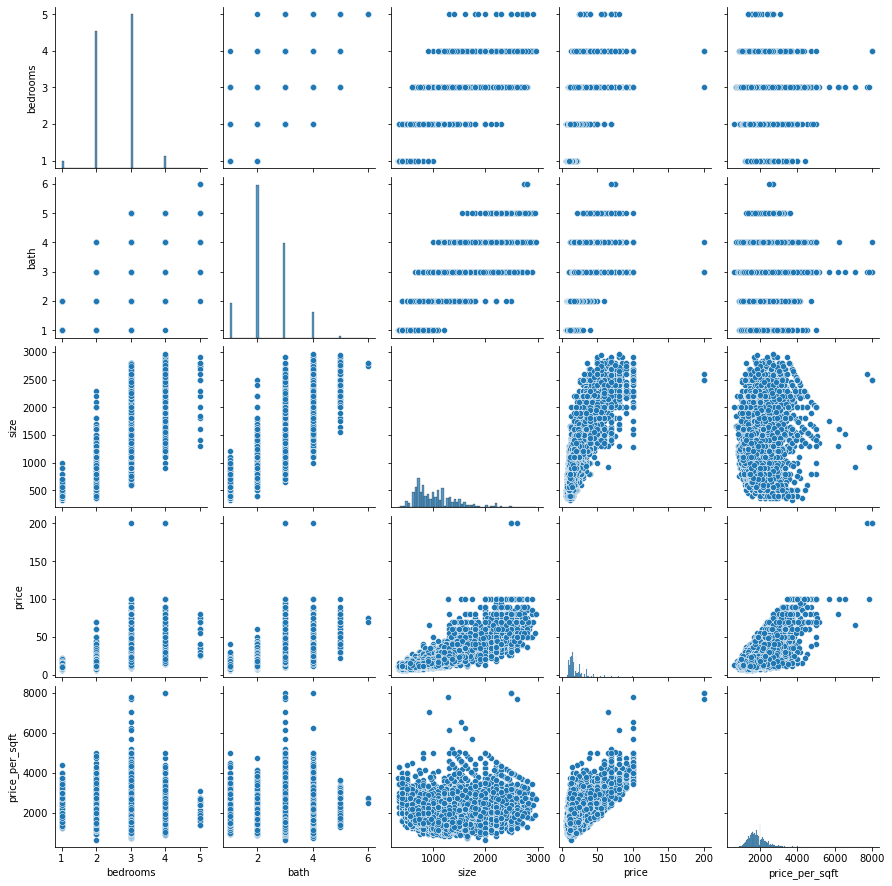

In [119]:
sns.pairplot(df9)

In [120]:
location_stats = df9.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats.head()

location
Mohammadpur,Dhaka          290
Dhanmondi,Dhaka            269
Mirpur,Dhaka               240
Sector10,Uttara,Dhaka      184
Kallyanpur,Mirpur,Dhaka    166
Name: location, dtype: int64

In [121]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10.head()

location
Kuratoli,Kuril,Dhaka                              10
BlockD,NobodoyHousingSociety,Mohammadpur,Dhaka    10
MollikaR/A,Section7,Mirpur,Dhaka                  10
BaganBari,Cantonment,Dhaka                        10
WestVatara,Vatara,Badda,Dhaka                     10
Name: location, dtype: int64

In [122]:
df9.location=df9.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df9.location.unique())

343

In [123]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key,subdf in df.groupby('location'):
        m=np.mean(subdf.price_per_sqft)
        st=np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df10 = remove_pps_outliers(df9)
df10.shape

(10877, 6)

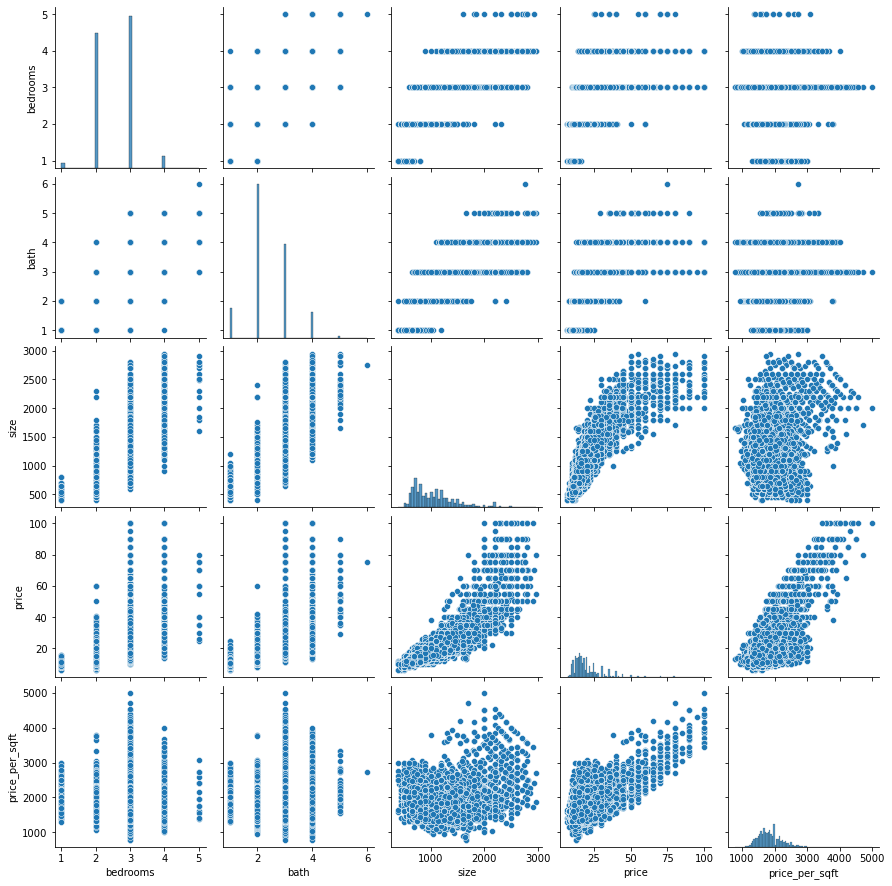

In [124]:
sns.pairplot(df10)

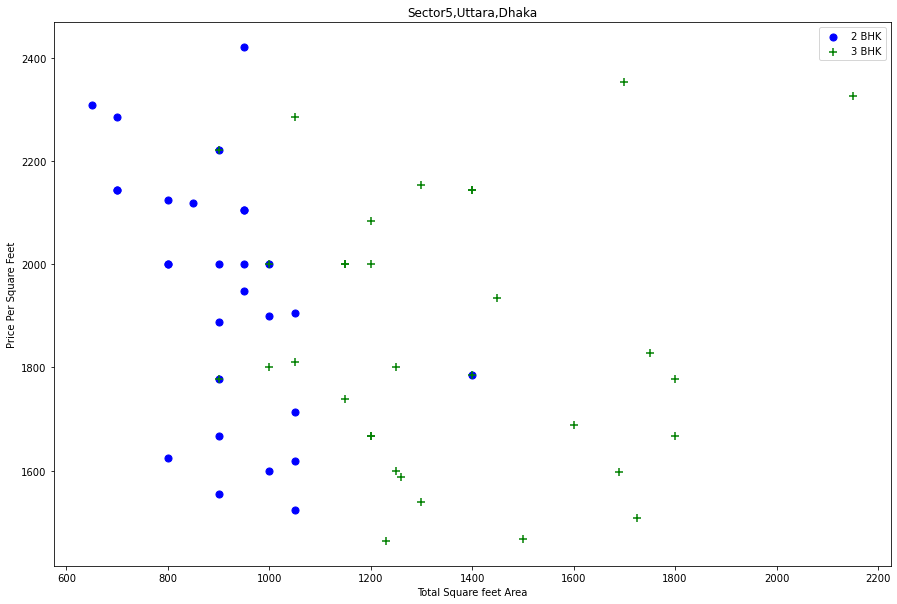

In [125]:
def plot_scatter_chart(df,location):
    bhk2=df[(df.location==location) & (df.bedrooms==2)]
    bhk3=df[(df.location==location) & (df.bedrooms==3)]
    matplotlib.rcParams['figure.figsize']=(15,10)
    plt.scatter(bhk2['size'],bhk2['price_per_sqft'],color='blue',label='2 BHK',s=50)
    plt.scatter(bhk3['size'],bhk3['price_per_sqft'],marker='+',color='green',label='3 BHK',s=50)
    plt.xlabel("Total Square feet Area")
    plt.ylabel("Price Per Square Feet")
    plt.title(location)
    plt.legend()

plot_scatter_chart(df10,"Sector5,Uttara,Dhaka")

In [126]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bedrooms'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bedrooms'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df11 = remove_bhk_outliers(df10)
# df8 = df7.copy()
df11.shape

(7334, 6)

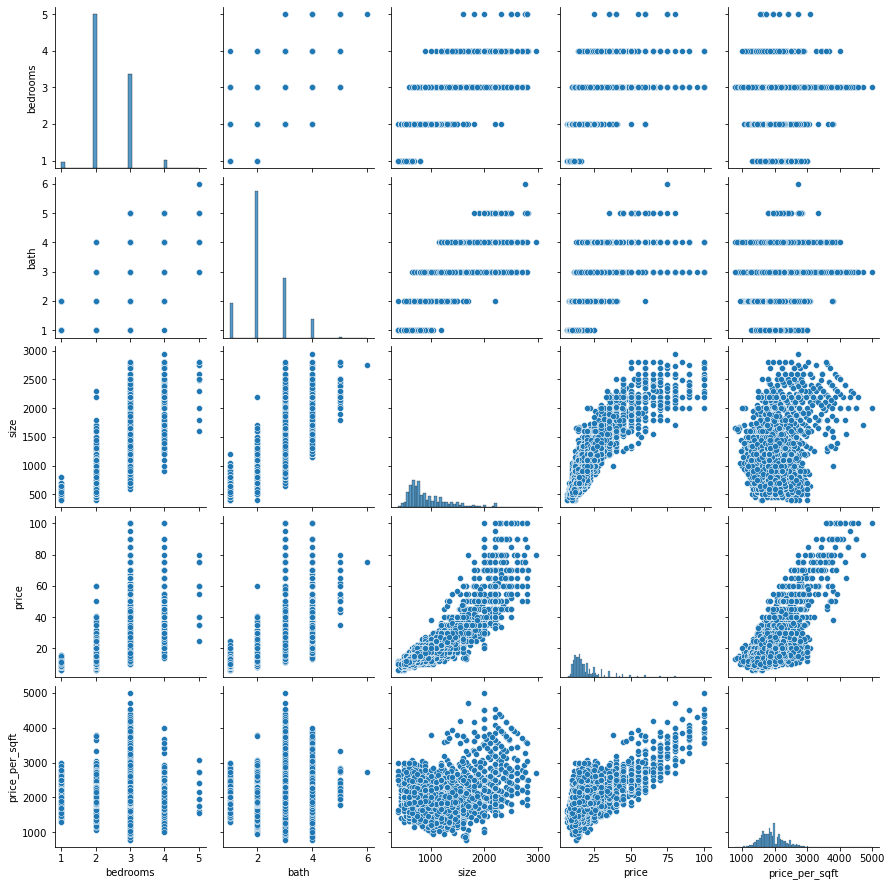

In [127]:
sns.pairplot(df11)

In [128]:
df12 = df11.drop('price_per_sqft',axis='columns')
df12.head(3)

,location,bedrooms,bath,size,price
0,"1stColony,Mirpur,Dhaka",2.0,2.0,600.0,10.5
1,"1stColony,Mirpur,Dhaka",2.0,2.0,700.0,12.0
2,"1stColony,Mirpur,Dhaka",2.0,2.0,800.0,13.5


In [129]:
df12.shape

(7334, 5)

C:\Users\zziid\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price', ylabel='size'>

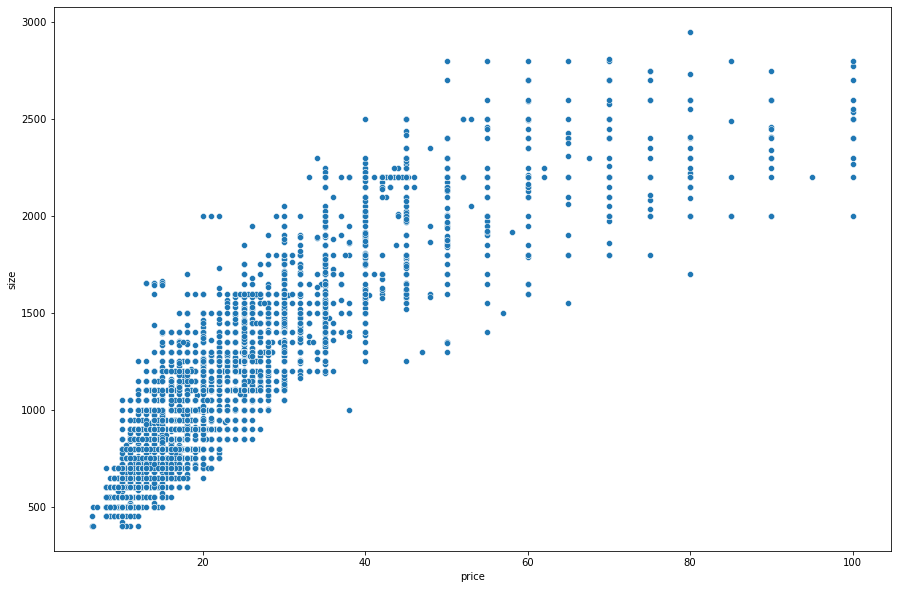

In [130]:
sns.scatterplot(df12['price'],df12['size'])

In [131]:
dummies = pd.get_dummies(df12.location)
dummies.head()

,"1stColony,Mirpur,Dhaka","2ndColony,Mirpur,Dhaka","3rdColony,Mirpur,Dhaka","Aainusbag,DakshinKhan,Dhaka","Abdullahbag,UttarBadda,Badda,Dhaka","AbdurRafiqueHousingSociety,Shekhertek,Mohammadpur,Dhaka","Adabor,Dhaka","Agargaon,Dhaka","AhmedNagar,Mirpur,Dhaka","AliAndNurRealEstate,Mohammadpur,Dhaka",...,"WestDolairpar,Shyampur,Dhaka","WestKafrul,Taltola,Agargaon,Dhaka","WestKalachandpur,Kalachandpur,Dhaka","WestKazipara,Mirpur,Dhaka","WestNakhalpara,Tejgaon,Dhaka","WestRampura,Rampura,Dhaka","WestShewrapara,Mirpur,Dhaka","Zafrabad,Hazaribag,Dhaka","azizMoholla,Mohammadpur,Dhaka",other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [132]:
df13 = pd.concat([df12,dummies.drop('other',axis='columns')],axis='columns')

In [133]:
df13 = df13.drop('location',axis='columns')

In [134]:
X = df13.drop(['price'],axis='columns')
X.head(3)

,bedrooms,bath,size,"1stColony,Mirpur,Dhaka","2ndColony,Mirpur,Dhaka","3rdColony,Mirpur,Dhaka","Aainusbag,DakshinKhan,Dhaka","Abdullahbag,UttarBadda,Badda,Dhaka","AbdurRafiqueHousingSociety,Shekhertek,Mohammadpur,Dhaka","Adabor,Dhaka",...,"WestDhanmondiandShangkar,Dhanmondi,Dhaka","WestDolairpar,Shyampur,Dhaka","WestKafrul,Taltola,Agargaon,Dhaka","WestKalachandpur,Kalachandpur,Dhaka","WestKazipara,Mirpur,Dhaka","WestNakhalpara,Tejgaon,Dhaka","WestRampura,Rampura,Dhaka","WestShewrapara,Mirpur,Dhaka","Zafrabad,Hazaribag,Dhaka","azizMoholla,Mohammadpur,Dhaka"
0,2.0,2.0,600.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.0,2.0,700.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.0,2.0,800.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [135]:
y = df13.price
y.head(3)

0    10.5
1    12.0
2    13.5
Name: price, dtype: float64

In [136]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [137]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.9482764477212575

In [138]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=10)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.94827645, 0.95219603, 0.95162271, 0.94333101, 0.95374372])

In [139]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

C:\Users\zziid\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
C:\Users\zziid\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model =

,model,best_score,best_params
0,linear_regression,0.945831,{'normalize': True}
1,lasso,0.776140,"{'alpha': 2, 'selection': 'random'}"
2,decision_tree,0.915164,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


In [140]:
def predict_price(location,bedrooms,bath,size):    
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = bedrooms
    x[1] = bath
    x[2] = size
    print(loc_index,x[0],x[1],x[2])
    if loc_index >= 0:
        x[loc_index] = 1

    return lr_clf.predict([x])[0]

In [141]:
predict_price('Sector5,Uttara,Dhaka',3,3,1600)

282 3.0 3.0 1600.0


C:\Users\zziid\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


32.80360426809061

In [143]:
predict_price('AhmedNagar,Mirpur,Dhaka',3,2,1600)

11 3.0 2.0 1600.0


C:\Users\zziid\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


28.111348795074733

In [145]:
predict_price('Bochila,Mohammadpur,Dhaka',4,3,1600)

140 4.0 3.0 1600.0


C:\Users\zziid\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


26.06197051912422

In [146]:
df12['location'].unique()

array(['1stColony,Mirpur,Dhaka', '2ndColony,Mirpur,Dhaka',
       '3rdColony,Mirpur,Dhaka', 'Aainusbag,DakshinKhan,Dhaka',
       'Abdullahbag,UttarBadda,Badda,Dhaka',
       'AbdurRafiqueHousingSociety,Shekhertek,Mohammadpur,Dhaka',
       'Adabor,Dhaka', 'Agargaon,Dhaka', 'AhmedNagar,Mirpur,Dhaka',
       'AliAndNurRealEstate,Mohammadpur,Dhaka', 'Amligola,Lalbagh,Dhaka',
       'Arambagh,Motijheel,Dhaka', 'Ashkona,DakshinKhan,Dhaka',
       'Avenue1,MirpurDOHS,Mirpur,Dhaka',
       'Avenue11,MirpurDOHS,Mirpur,Dhaka',
       'Avenue2,MirpurDOHS,Mirpur,Dhaka',
       'Avenue3,MirpurDOHS,Mirpur,Dhaka',
       'Avenue4,MirpurDOHS,Mirpur,Dhaka',
       'Avenue5,BlockC,Section11,Mirpur,Dhaka',
       'Avenue6,MirpurDOHS,Mirpur,Dhaka', 'Azimpur,Lalbagh,Dhaka',
       'Badda,Dhaka', 'Baigertek,Cantonment,Dhaka',
       'BaitulAmanHousingSociety,Adabor,Dhaka', 'Banani,Dhaka',
       'Banasree,Dhaka', 'Bangshal,Dhaka', 'Baridhara,Dhaka',
       'BaridharaDOHS,Dhaka', 'Barontek,Cantonment,Dhaka